# Custom Classifier: Advanced Machine Learning
# The Super Learner

#### Import Packages Etc

In [2]:
from IPython.display import display, HTML, Image

from sklearn.base import BaseEstimator, ClassifierMixin

# Add more packages as required
import pandas as pd
import numpy as np
import time

from sklearn.tree import DecisionTreeClassifier
from scipy.spatial import distance
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn import linear_model
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import KFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import label_binarize
from sklearn import metrics
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted
from sklearn.model_selection import GridSearchCV
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics import roc_curve, auc
from sklearn import cross_validation
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import SGDClassifier
import re
from itertools import combinations
import random
from datetime import datetime

import matplotlib.pyplot as plt
from matplotlib import pyplot
from matplotlib import colors
%matplotlib inline
#%qtconsole

## Define Super Learner Classifier

The *Super Learner* is a heterogeneous stacked ensemble classifier. This is a classification model that uses a set of base classifiers of different types, the outputs of which are then combined in another classifier at the stacked layer. The Super Learner was described in [(van der Laan et al, 2007)](https://pdfs.semanticscholar.org/19e9/c732082706f39d2ba12845851309714db135.pdf) but the stacked ensemble idea has been around for a long time. 

Figure 1 shows a flow diagram of the Super Learner process (this is from (van der Laan et al, 2007) and the process is also described in the COMP47590 lecture "[COMP47590 2017-2018 L04 Supervised Learning Ensembles 3](https://www.dropbox.com/s/1ksx94nxtuyn4l8/COMP47590%202017-2018%20L04%20Supervised%20Learning%20Ensembles%203.pdf?raw=1)"). The base classifiers are trained and their outputs are combined along with the training dataset labels into a training set for the stack layer classifier. To avoid overfitting the generation of the stacked layer training set uses a k-fold cross validation process (described as V-fold in Figure 1). To further add variety to the base estimators a bootstrapping selection (as is used in the bagging ensemble approach).
 
![Super Learner Process Flow](SuperLearnerProcessFlow.png "Logo Title Text 1")
Figure 1: A flow diagram for the Super Learner


### Define the SuperLearnerClassifier Class

Following is the list of available base classifier for our Superlearner

In [3]:
print("Start Time: ")
str(datetime.now())

Start Time: 


'2018-03-09 14:52:20.212982'

In [4]:
clf_base_lr = LogisticRegression(multi_class='ovr', solver='liblinear')
clf_base_rf = RandomForestClassifier(n_estimators=51, max_depth = 4, min_samples_split = 50)
clf_base_nb = GaussianNB()
clf_base_knn = KNeighborsClassifier(n_neighbors=5)
clf_base_dt = DecisionTreeClassifier(max_depth = 4, min_samples_split = 50 )
clf_base_svc = SVC(kernel = 'linear', probability=True)
clf_base_sgd = SGDClassifier(loss="log", penalty="l2")
clf_base_ada = AdaBoostClassifier(n_estimators=51)
clf_base_gb = GradientBoostingClassifier(n_estimators=50, learning_rate=0.2)

clf_base_default = [clf_base_lr, clf_base_rf, clf_base_nb, clf_base_knn, clf_base_dt, clf_base_svc]
clf_base_all = [clf_base_lr, clf_base_rf, clf_base_nb, clf_base_knn, clf_base_dt, clf_base_svc, clf_base_sgd, clf_base_ada, clf_base_gb]

Following is the list of available stack classifier for our Superlearner

In [5]:
clf_stack_lr = LogisticRegression(multi_class='ovr', solver='liblinear')
clf_stack_rf = RandomForestClassifier(n_estimators=51, max_depth = 4, min_samples_split = 50)
clf_stack_nb = GaussianNB()
clf_stack_knn = KNeighborsClassifier(n_neighbors=5)
clf_stack_dt = DecisionTreeClassifier(max_depth = 4, min_samples_split = 50 )
clf_stack_svc = SVC(kernel = 'linear', probability=True)
clf_stack_sgd = SGDClassifier(loss="log", penalty="l2")
clf_stack_ada = AdaBoostClassifier(n_estimators=51)
clf_stack_gb = GradientBoostingClassifier(n_estimators=50, learning_rate=0.2)

In [23]:
# Create a new classifier which is based on the sckit-learn BaseEstimator and ClassifierMixin classes
class SuperLearnerClassifier(BaseEstimator, ClassifierMixin):
    
    # Constructor for the classifier object
    def __init__(self, clfs=clf_base_default, stacked_clf=clf_stack_dt, training='label', useEntireData='False', randomN=None):
    
        # If randomN parameter is passed then overwrite the clfs parameter and select N random classifer from our overall list
        if randomN:
            clfs=random.sample(clf_base_all, k=randomN)
            print("Random", randomN, "classifiers chosen")
            print(clfs)
        
        # Set parameter values
        self.clfs = clfs
        self.stacked_clf = stacked_clf
        self.training = training
        self.kFolds = 4
        self.useEntireData = useEntireData
        
        
    # The fit function to train a classifier
    def fit(self, X, y):
            
        # Check if X & y have similar dimensions
        X, y = check_X_y(X, y)
            
        # Set number of folds
        kf = KFold(n_splits=self.kFolds)
            
        fit_pred_one = pd.DataFrame()     
        self.y_kfold_data = []
        self.stackData = pd.DataFrame()
        
        # Create input data for stacked model using 4-Fold 
        for train_index, test_index in kf.split(X):
            X_train, X_test = np.array(X)[train_index], np.array(X)[test_index]
            y_train, y_test = np.array(y)[train_index], np.array(y)[test_index]
            self.y_kfold_data.extend(y_test)
            fit_pred = pd.DataFrame()
            for clf in self.clfs:
                
                # Bagging of classifier
                clf = BaggingClassifier(clf)
                
                clf.fit(X_train,y_train)
                
                # Check if labels or probability is required as the output from the base classifiers
                if self.training == 'label':
                    fit_pred_one = clf.predict(X_test)
                else:
                    fit_pred_one = clf.predict_proba(X_test)
                fit_pred_one = pd.DataFrame(fit_pred_one)
                
                # Append data columns wise and rows wise 
                fit_pred = pd.concat([fit_pred, fit_pred_one], axis = 1)
            self.stackData = pd.concat([self.stackData, fit_pred], axis = 0)
         
        # Fit all(100%) data in base learners once we have created input data for our stacked layer
        for clf in self.clfs:
            clf.fit(X,y)    
        
        # Add raw data if needed
        if self.useEntireData == 'True':
            self.stackData.reset_index(inplace=True, drop=True)
            X_temp = pd.DataFrame(X).reset_index(drop=True)
            self.stackData = pd.concat([self.stackData, X_temp], axis = 1)
                
        # Fit data into stacked classifier
        self.stacked_clf.fit(self.stackData, self.y_kfold_data)
        
        # Return the classifier
        return self

    # The predict function to make a set of predictions for a set of query instances
    def predict(self, X):
        
        # Check is fit had been called by confirming that the teamplates_ dictiponary has been set up
        check_is_fitted(self, ['stackData'])

        pred_one = pd.DataFrame()
        pred = pd.DataFrame()
        
        # Create dataset similar to what was fitted to the stacked layer
        for clf in self.clfs:
            if self.training == 'label':
                pred_one = clf.predict(X)
            else:
                pred_one = clf.predict_proba(X)
            pred_one = pd.DataFrame(pred_one)
            pred = pd.concat([pred, pred_one], axis = 1)
            
        if self.useEntireData == 'True':
            pred.reset_index(inplace=True, drop=True)
            X_temp = pd.DataFrame(X).reset_index(drop=True)
            pred = pd.concat([pred, X_temp], axis = 1)
        
        # Check that the input features match the type and shape of the training features
        pred = check_array(pred)
        
        # Predict labels using stacked classifier
        stacked_pred = self.stacked_clf.predict(pred)
        
        # Return predictions
        return stacked_pred
    
    # The predict function to make a set of predictions for a set of query instances
    def predict_proba(self, X):
        
        # Check is fit had been called by confirming that the teamplates_ dictiponary has been set up
        check_is_fitted(self, ['stackData'])

        pred_one = pd.DataFrame()
        pred = pd.DataFrame()
        
         # Create dataset similar to what was fitted to the stacked layer
        for clf in self.clfs:
            if self.training == 'label':
                pred_one = clf.predict(X)
            else:
                pred_one = clf.predict_proba(X)
            pred_one = pd.DataFrame(pred_one)
            pred = pd.concat([pred, pred_one], axis = 1)
            
        if self.useEntireData == 'True':
            pred.reset_index(inplace=True, drop=True)
            X_temp = pd.DataFrame(X).reset_index(drop=True)
            pred = pd.concat([pred, X_temp], axis = 1)
            
        # Check that the input features match the type and shape of the training features
        pred = check_array(pred)
        
        # Predict probabilities using stacked classifier
        stacked_proba_pred = self.stacked_clf.predict_proba(pred)
        
        # Return predicted probabilities
        return stacked_proba_pred
    
    def base_model_eval(self):
        
        eval_data = self.stackData
        y_original = self.y_kfold_data
        base_model_accuracy_comparison = dict()
        used_model_list = []
        
        # Calculate accuracy of every base classifier
        count = 0
        for column in eval_data:
            accuracy = metrics.accuracy_score(y_original, eval_data.iloc[:,count])
            clf_string = str(self.clfs[count])
            model = re.split(r'\(', clf_string)[0]
            base_model_accuracy_comparison[model] = accuracy
            used_model_list.append(model)
            count += 1 
            
        # Calculate the diversity between base classifiers by finding the percent of overlap between them.
        # More the overlap, less diversity will be present and vice versa
        eval_data.columns = used_model_list
        val = eval_data.values
        model_overlap_dict = {(i, j): np.mean(val[:, i] == val[:, j]) for i, j in combinations(range(val.shape[1]), 2)}
        result, c, vals = np.zeros((val.shape[1], val.shape[1])), \
                   list(map(list, zip(*model_overlap_dict.keys()))), list(model_overlap_dict.values())

        result[c[0], c[1]] = vals

        model_overlap = pd.DataFrame(result, columns=used_model_list, index=used_model_list)
           
        # Return overlap between models along with their accuracy
        return model_overlap, base_model_accuracy_comparison

### Test the SuperLearnerClassifier

Perform a simple test using the SuperLearnClassifier on the Iris dataset

In [7]:
from sklearn.datasets import load_iris
clf = SuperLearnerClassifier()
iris = load_iris()
clf.fit(iris.data, iris.target)
cross_val_score(clf, iris.data, iris.target, cv=10, verbose=0)

array([0.93333333, 0.93333333, 1.        , 1.        , 0.86666667,
       1.        , 0.93333333, 0.66666667, 1.        , 1.        ])

## Load & Partition Data

### Setup - IMPORTANT

Take only a sample of the dataset for fast testing

In [8]:
data_sampling_rate = 0.05

Setup the number of folds for all grid searches (should be 5 - 10)

In [9]:
cv_folds = 5

### Load Dataset

Load the dataset and explore it.

In [10]:
dataset = pd.read_csv('fashion-mnist_train.csv')
dataset = dataset.sample(frac=data_sampling_rate) #take a sample from the dataset so everyhting runs smoothly
num_classes = 10
classes = {0: "T-shirt/top", 1:"Trouser", 2: "Pullover", 3:"Dress", 4:"Coat", 5:"Sandal", 6:"Shirt", 7:"Sneaker", 8:"Bag", 9:"Ankle boot"}
display(dataset.head())

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
52634,1,0,0,0,0,0,0,0,12,15,...,20,16,15,16,0,0,0,0,0,0
19416,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
12820,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
35250,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7782,6,0,0,0,0,0,0,0,2,2,...,0,0,0,0,115,122,34,0,0,0


### Pre-process & Partition Data

Perform data pre-processing and manipulation as required

In [11]:
# Add code here
X = dataset[dataset.columns[1:]]
Y = np.array(dataset["label"])

In [12]:
X = X/255

In [13]:
X_train_plus_valid, X_test, y_train_plus_valid, y_test \
    = train_test_split(X, Y, random_state=0, \
                                    train_size = 0.7)

X_train, X_valid, y_train, y_valid \
    = train_test_split(X_train_plus_valid, \
                                        y_train_plus_valid, \
                                        random_state=0, \
                                        train_size = 0.5/0.7)


## Train and Evaluate a Simple Model

Train a Super Learner Classifier using the prepared dataset

## Task 1: Call SuperLearner

Call superlearner for predefined 6 base classifiers

In [13]:
np.random.seed(123)

# Below is the list of default classifiers which were included at the beginning of the code
# clf_base_default = [clf_base_lr, clf_base_rf, clf_base_nb, clf_base_knn, clf_base_dt, clf_base_svc]
# Pass the clf_base_default value to the 'clf' parameter

my_model_q1 = SuperLearnerClassifier(clfs=clf_base_default, stacked_clf=clf_stack_knn, training='label')
my_model_q1.fit(X_train, y_train)

SuperLearnerClassifier(clfs=[LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False), RandomForestClassifier(boots...r',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)],
            randomN=None,
            stacked_clf=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform'),
            training='label', useEntireData='False')

Evaluate the trained classifier

In [14]:
# Make a set of predictions for the training data
y_pred = my_model_q1.predict(X_test)

# Print performance details
accuracy = metrics.accuracy_score(y_test, y_pred) # , normalize=True, sample_weight=None
print("Accuracy: " +  str(accuracy))
print(metrics.classification_report(y_test, y_pred))

# Print confusion matrix
#print(metrics.confusion_matrix(y_train, y_pred))

# Print nicer homemade confusion matrix
print("Confusion Matrix")
display(pd.crosstab(np.array(y_test), y_pred, rownames=['True'], colnames=['Predicted'], margins=True))

Accuracy: 0.7711111111111111
             precision    recall  f1-score   support

          0       0.75      0.79      0.77       104
          1       0.88      0.94      0.91        89
          2       0.60      0.69      0.64        97
          3       0.77      0.76      0.77        84
          4       0.68      0.67      0.67        90
          5       0.85      0.88      0.87       107
          6       0.41      0.30      0.35        64
          7       0.79      0.83      0.81        72
          8       0.88      0.75      0.81        87
          9       0.93      0.93      0.93       106

avg / total       0.77      0.77      0.77       900

Confusion Matrix


Predicted,0,1,2,3,4,5,6,7,8,9,All
True,,,,,,,,,,,
0,82,3,8,2,0,0,7,0,2,0,104
1,2,84,0,3,0,0,0,0,0,0,89
2,1,0,67,1,17,1,8,0,2,0,97
3,5,7,2,64,1,1,4,0,0,0,84
4,0,0,12,10,60,1,7,0,0,0,90
5,0,0,1,0,1,94,0,8,1,2,107
6,12,1,15,1,8,8,19,0,0,0,64
7,0,0,0,0,0,4,0,60,2,6,72
8,7,0,6,2,1,1,1,4,65,0,87


## Task 2: Cross Validation Experiment

Perfrom a 10-fold cross validation experiment to evaluate the performance of the SuperLearnerClassifier

In [15]:
# Add code here
my_model_q2 = SuperLearnerClassifier(clfs=clf_base_default, stacked_clf=clf_stack_rf, training='label')

#my_model.fit(X_train, y_train)
cross_validation.cross_val_score(my_model_q2, X_test, y_test, cv=10, scoring='accuracy')

array([0.79787234, 0.77659574, 0.83870968, 0.75268817, 0.82222222,
       0.76666667, 0.76404494, 0.76744186, 0.76744186, 0.76470588])

The accuracy varies from 75% to 83% during the cross validation

## Task 3: Label vs Probability

Generate the labels as the training dataset for the stacked layer

In [16]:
# Set "training='label'" to train on the labels
my_model_q3_label = SuperLearnerClassifier(clfs=clf_base_default, stacked_clf=clf_stack_nb, training='label')
my_model_q3_label.fit(X_train, y_train)
    
# Display head of input data of stack layer : labels
my_model_q3_label.stackData.head()

,0,0,0,0,0,0
0,4,4,4,2,2,4
1,3,0,0,0,0,0
2,4,4,4,4,4,4
3,0,0,0,0,0,0
4,4,3,3,4,3,4


Generate the probabilities as the input for the staked classifier

In [17]:
# Set "training='probaility'" to train on the labels
my_model_q3_proba = SuperLearnerClassifier(clfs=clf_base_default, stacked_clf=clf_stack_knn, training='probability')
my_model_q3_proba.fit(X_train, y_train)

# Display head of input data of stack layer : probability
my_model_q3_proba.stackData.head()

,0,1,2,3,4,5,6,7,8,9,...,0,1,2,3,4,5,6,7,8,9
0,1.527835e-02,0.002283,0.137461,3.186668e-02,0.387149,0.011911,0.395731,4.662876e-05,0.016255,0.002019,...,0.058083,0.014135,0.224443,0.049820,0.398173,0.018329,0.200064,0.007199,0.021210,0.008545
1,2.239749e-01,0.215332,0.105032,2.857483e-01,0.001673,0.002162,0.033912,6.754633e-02,0.019794,0.044825,...,0.289236,0.149530,0.046699,0.136599,0.024198,0.098244,0.161853,0.052936,0.024594,0.016113
2,2.155764e-07,0.000073,0.109816,4.462309e-08,0.825653,0.000004,0.064407,1.252925e-09,0.000044,0.000004,...,0.003099,0.006804,0.179108,0.001122,0.554086,0.001335,0.245844,0.001801,0.005598,0.001204
3,9.398384e-01,0.000146,0.018504,5.506390e-04,0.000424,0.000014,0.038226,4.840406e-06,0.002121,0.000171,...,0.837494,0.003725,0.014063,0.007505,0.005835,0.001165,0.120149,0.001284,0.006753,0.002027
4,9.548935e-03,0.176716,0.000038,7.818318e-03,0.798809,0.000014,0.005220,2.448623e-04,0.000794,0.000798,...,0.050779,0.234571,0.030952,0.081191,0.451092,0.009392,0.094533,0.011777,0.026643,0.009069


## Task 4: Different Models for stack layer

Using of different classifiers in the stacked layer

In [18]:
# Using Decision Tree by changing value for 'stacked_clf' parameter
my_model_q4 = SuperLearnerClassifier(clfs=clf_base_default, stacked_clf=clf_stack_dt, training='label')
my_model_q4.fit(X_train, y_train)
y_pred = my_model_q4.predict(X_test)

# Print performance details
accuracy = metrics.accuracy_score(y_test, y_pred)
print("Accuracy: " +  str(accuracy))

Accuracy: 0.8011111111111111


In [19]:
# Using Logistic Regression by changing value for 'stacked_clf' parameter
my_model_q4 = SuperLearnerClassifier(clfs=clf_base_default, stacked_clf=clf_stack_lr, training='label')
my_model_q4.fit(X_train, y_train)
y_pred = my_model_q4.predict(X_test)

# Print performance details
accuracy = metrics.accuracy_score(y_test, y_pred)
print("Accuracy: " +  str(accuracy))

Accuracy: 0.5844444444444444


Observation: Accuracy can vary drastically depending on what model we use at the stacked layer.

## Task 5: Comparing the Performance of Different Stack Layer Approaches

Compare the performance of the ensemble when a label based stack layer training set and a probability based stack layer training set is used.

In [20]:
# Keeping the 'clf' constant change the value of 'stacked_clf' and 'training' parameter
model_test_accuracy_comparisons = dict()

my_model_q5_1 = SuperLearnerClassifier(clfs=clf_base_default, stacked_clf=clf_stack_dt, training='label')
my_model_q5_1.fit(X_train, y_train)
y_pred = my_model_q5_1.predict(X_test)
accuracy = metrics.accuracy_score(y_test, y_pred)
model_test_accuracy_comparisons["DT_Label"] = accuracy

my_model_q5_2 = SuperLearnerClassifier(clfs=clf_base_default, stacked_clf=clf_stack_dt, training='probability')
my_model_q5_2.fit(X_train, y_train)
y_pred = my_model_q5_2.predict(X_test)
accuracy = metrics.accuracy_score(y_test, y_pred)
model_test_accuracy_comparisons["DT_Proba"] = accuracy

my_model_q5_3 = SuperLearnerClassifier(clfs=clf_base_default, stacked_clf=clf_stack_lr, training='label')
my_model_q5_3.fit(X_train, y_train)
y_pred = my_model_q5_3.predict(X_test)
accuracy = metrics.accuracy_score(y_test, y_pred)
model_test_accuracy_comparisons["LR_Label"] = accuracy

my_model_q5_4 = SuperLearnerClassifier(clfs=clf_base_default, stacked_clf=clf_stack_lr, training='probability')
my_model_q5_4.fit(X_train, y_train)
y_pred = my_model_q5_4.predict(X_test)
accuracy = metrics.accuracy_score(y_test, y_pred)
model_test_accuracy_comparisons["LR_Proba"] = accuracy

display(model_test_accuracy_comparisons)


{'DT_Label': 0.7966666666666666,
 'DT_Proba': 0.6233333333333333,
 'LR_Label': 0.5411111111111111,
 'LR_Proba': 0.8288888888888889}

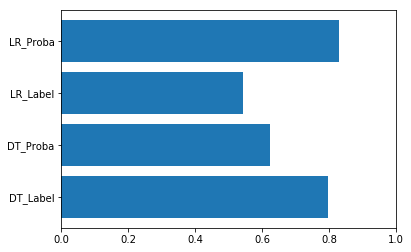

In [21]:
# Display the graph for performance comparison
plt.xlim(0, 1.0)
_ = plt.barh(range(len(model_test_accuracy_comparisons)), list(model_test_accuracy_comparisons.values()), align='center')
_ = plt.yticks(range(len(model_test_accuracy_comparisons)), list(model_test_accuracy_comparisons.keys()))

## Task 6: Pass the base classifiers as a specific list or select random N number of it

Pass as a specific list

In [22]:
# Pass a list of classifier to the 'clfs' parameter
my_model_q6 = SuperLearnerClassifier(clfs=[clf_base_knn,clf_base_svc, clf_base_nb], stacked_clf=clf_stack_lr, training='label')
my_model_q6.fit(X_train, y_train)
y_pred = my_model_q6.predict(X_test)

# Print performance details
accuracy = metrics.accuracy_score(y_test, y_pred)
print("Accuracy: " +  str(accuracy))

Accuracy: 0.5288888888888889


Select random classifiers as per the number passed via the parameter.

When 'randomN' parameter is passed it will override the 'clfs' parameter and will select random N number of classifiers.

In [23]:
# Pass the parameter 'randomN' with the number of random base classifier required
my_model_q6_b = SuperLearnerClassifier(clfs=[clf_base_knn,clf_base_svc, clf_base_nb], stacked_clf=clf_stack_lr, training='label', randomN=4)
my_model_q6_b.fit(X_train, y_train)
y_pred = my_model_q6_b.predict(X_test)

# Print performance details
accuracy = metrics.accuracy_score(y_test, y_pred)
print("Accuracy: " +  str(accuracy))

Random 4 classifiers chosen
Accuracy: 0.5366666666666666


## Grid Search Through SuperLearnerClassifier Architectures & Parameters (Task 7)

Perfrom a grid search experiment to detemrine the optimal architecture and hyper-parameter values for the SuperLearnClasssifier for the MNIST Fashion classification problem.

Tried experimenting with the different parameters but it's getting computationally expensive.
So for now I have tried to keep things minimum to show the functionality of the GridSearch with SuperLearner. Following number of parameters are used:

clfs: 1<br>
stacked_clf: 2<br>
training: 2<br>
cv: 2

In [15]:
# Set up the parameter grid to seaerch
param_grid = [
 {'clfs': [[clf_base_lr, clf_base_rf, clf_base_nb, clf_base_knn, clf_base_dt, clf_base_svc]],
  'stacked_clf': [clf_stack_knn, clf_stack_dt ],
  'training': ['label', 'probability']
 }
]

# Perform the search
my_tuned_model = GridSearchCV(SuperLearnerClassifier(), param_grid, cv=2, verbose = 2, n_jobs=1)
my_tuned_model.fit(X_train, y_train)

# Print details
print("Best parameters set found on development set:")
print(my_tuned_model.best_params_)
print(my_tuned_model.best_score_)


Fitting 2 folds for each of 4 candidates, totalling 8 fits
[CV] clfs=[LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False), RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=4, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=50, min_weight_fraction_leaf=0.0,
            n_estimators=51, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False), GaussianNB(priors=None), KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform'), DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=4,
            max_fea

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   54.2s remaining:    0.0s


[CV]  clfs=[LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False), RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=4, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=50, min_weight_fraction_leaf=0.0,
            n_estimators=51, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False), GaussianNB(priors=None), KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform'), DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=4,
            max_features=None, max_leaf_nodes=None,
            min_impurity_

[CV]  clfs=[LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False), RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=4, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=50, min_weight_fraction_leaf=0.0,
            n_estimators=51, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False), GaussianNB(priors=None), KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform'), DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=4,
            max_features=None, max_leaf_nodes=None,
            min_impurity_

[CV]  clfs=[LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False), RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=4, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=50, min_weight_fraction_leaf=0.0,
            n_estimators=51, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False), GaussianNB(priors=None), KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform'), DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=4,
            max_features=None, max_leaf_nodes=None,
            min_impurity_

[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:  7.1min finished


Best parameters set found on development set:
{'clfs': [LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False), RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=4, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=50, min_weight_fraction_leaf=0.0,
            n_estimators=51, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False), GaussianNB(priors=None), KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform'), DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=4,
            max_features=None, ma

Evaluate the performance of the model selected by the grid search on a hold-out dataset

In [18]:
# Check accuracy for the best parameters selected by GridSearch
my_model_q7_eval = SuperLearnerClassifier(clfs=[clf_base_lr, clf_base_rf, clf_base_nb, clf_base_knn, clf_base_dt, clf_base_svc], stacked_clf=clf_stack_knn, training='probability')
my_model_q7_eval.fit(X_train, y_train)
y_pred = my_model_q7_eval.predict(X_valid)

# Print performance details
accuracy = metrics.accuracy_score(y_valid, y_pred)
print("Accuracy: " +  str(accuracy))

Accuracy: 0.7933333333333333


Observation: Initially during our cross validation we were getting accuracy around 77%. After using different hyper parameters with GridSearch, our accuracy increased to 79.33%

## Evaluating the Impact of Adding Original Descriptive Features at the Stack Layer (Task 8)

Evaluate the impact of adding original descriptive features at the stack layer.

Additional parameter required for that would "useEntireData=True"

In [32]:
# Pass the parameter "useEntireData=True"
my_model_q8 = SuperLearnerClassifier(clfs=clf_base_default, stacked_clf=clf_stack_knn, training='label', useEntireData='True')
my_model_q8.fit(X_train, y_train)
y_pred = my_model_q8.predict(X_valid)

# Print performance details
accuracy = metrics.accuracy_score(y_valid, y_pred)
print("Accuracy: " +  str(accuracy))

Accuracy: 0.7983333333333333


By using the entire data we can observe that the Accuracy jumped by around 2.7%<br>
Without original features: 77.11%<br>
With Original features: 79.83%

## Explore the Ensemble Model (Task 9)

Perform an analysis to investigate the strength of the base estimators and the strengths of the correlations between them.

In [20]:
# Add code here
my_model_q9 = SuperLearnerClassifier(clfs=clf_base_default, stacked_clf=clf_stack_knn, training='label')
my_model_q9.fit(X_train, y_train)

# Get the accuracy of each model and the overlap between the model
base_model_relation, base_accuracy_comparison = my_model_q9.base_model_eval()

{'DecisionTreeClassifier': 0.698,
 'GaussianNB': 0.5686666666666667,
 'KNeighborsClassifier': 0.7573333333333333,
 'LogisticRegression': 0.8006666666666666,
 'RandomForestClassifier': 0.738,
 'SVC': 0.802}

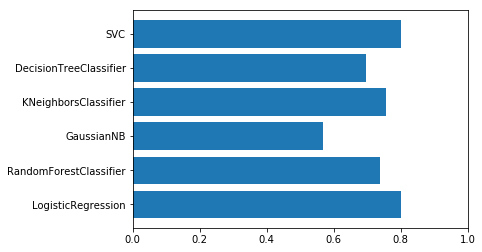

In [21]:
# Displays the accuracy of all the base classifiers
display(base_accuracy_comparison)
plt.xlim(0, 1.0)
_ = plt.barh(range(len(base_accuracy_comparison)), list(base_accuracy_comparison.values()), align='center')
_ = plt.yticks(range(len(base_accuracy_comparison)), list(base_accuracy_comparison.keys()))

#### Check diversity between base learners predictions
Calculate the overlap between the label output of the classifier. It finds the relation between output by comparing how may value are predicted same by two classifier divided by total number of predictions made.

Overlap_ratio = Same Predictions / Total Predictions



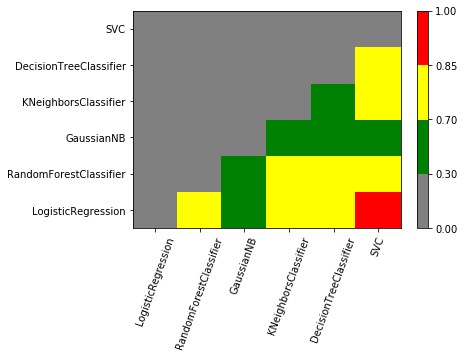

In [22]:
# Folliwng heatmap will show the percentage overlap between results of different base models.
# There's a scale along with the heatmap which shows the level of overlap. 
# Its actually a tradeoff between each model accuracy and the overlap across the two. Each model should have high accuracy independently while they shouldn't have too much of an overlap to keep up with the diversity. 
# The color scale could vary and it could be a good idea to have a diversity in the upper green or yellow zone.

cmap = colors.ListedColormap(['grey','green','yellow','red'])
bounds=[0, 0.3, 0.7, 0.85, 1]
norm = colors.BoundaryNorm(bounds, cmap.N)
plt.pcolor(base_model_relation, cmap=cmap, norm=norm)
plt.yticks(np.arange(0.5, len(base_model_relation.index), 1), base_model_relation.index)
plt.xticks(np.arange(0.5, len(base_model_relation.columns), 1), base_model_relation.columns, rotation=70)
plt.colorbar()
plt.show()

Red block (85% - 100%): High overlap between SVC and LR <br>
Yellow block (70% - 85%): Acceptable overlap. They have decent amount of diversity<br>
Green block (30% - 70%): Low overlap between the models. High diversity present.

In [37]:
# Overlap score ratio between differnt base models.
base_model_relation

,LogisticRegression,RandomForestClassifier,GaussianNB,KNeighborsClassifier,DecisionTreeClassifier,SVC
LogisticRegression,0.0,0.808,0.639333,0.806000,0.714000,0.906667
RandomForestClassifier,0.0,0.000,0.692000,0.799333,0.826000,0.808000
GaussianNB,0.0,0.000,0.000000,0.627333,0.607333,0.632667
KNeighborsClassifier,0.0,0.000,0.000000,0.000000,0.699333,0.826667
DecisionTreeClassifier,0.0,0.000,0.000000,0.000000,0.000000,0.715333
SVC,0.0,0.000,0.000000,0.000000,0.000000,0.000000


In [38]:
print("End Time (If only it will ever end): ")
str(datetime.now())

End Time (If only it will ever end): 


'2018-03-09 09:44:02.842640'